In [1]:
import os

import pandas as pd
import numpy as np

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, f1_score, precision_score ,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics

  
import joblib

### Model.pkl File Paths

In [2]:
lgr_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_lgr.pkl"
dt_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_dt.pkl"
knn_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_knn.pkl"
gnb_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_gnb.pkl"
rfc_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_rfc.pkl"
rfr_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_rfr.pkl"
cv_rfr_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_cv_rfr.pkl"
lr_modelPath = "/data/asjad/Project/venv/venv/burger_joint/models/bj_lr.pkl"


### Getting data from the database

In [3]:
#establishing the connection
conn = psycopg2.connect(
   database="burgersale", user='asjad', password='asjad', host='127.0.0.1', port= '5432'
)
#Creating a cursor object using the cursor() method
#cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
sqlQuery = "select customer_id, extract(epoch from tx_datetime::timestamptz) as datetime, tx_amount, terminal_id, tx_type from mynewtable"

# Fetch a single row using fetchone() method.
data = pd.read_sql(sqlQuery, conn)
#print(data)

#Closing the connection
conn.close()

/data/asjad/Project/venv/venv/lib64/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### EDA

In [4]:
data

,customer_id,datetime,tx_amount,terminal_id,tx_type
0,28,1.522539e+09,84.230003,17,0
1,296,1.522585e+09,120.649994,15,3
2,188,1.522543e+09,53.290001,16,0
3,188,1.522548e+09,29.950001,16,0
4,188,1.522549e+09,10.310000,16,0
...,...,...,...,...,...
4740,467,1.532853e+09,78.720001,17,2
4741,467,1.532923e+09,47.520000,16,0
4742,467,1.532952e+09,125.110001,18,3
4743,467,1.533008e+09,185.113356,16,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4745 entries, 0 to 4744
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  4745 non-null   int64  
 1   datetime     4745 non-null   float64
 2   tx_amount    4745 non-null   float64
 3   terminal_id  4745 non-null   int64  
 4   tx_type      4745 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 185.5 KB


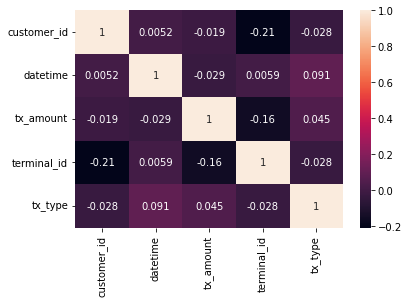

In [6]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

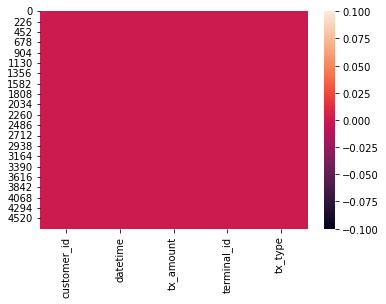

In [7]:
sns.heatmap(data.isnull())
plt.show()

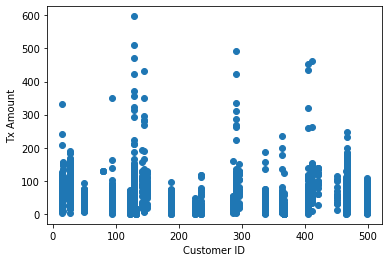

In [8]:
plt.scatter(data['customer_id'],data['tx_amount'])
plt.xlabel('Customer ID')
plt.ylabel('Tx Amount')
plt.show()


<AxesSubplot:xlabel='tx_type', ylabel='terminal_id'>

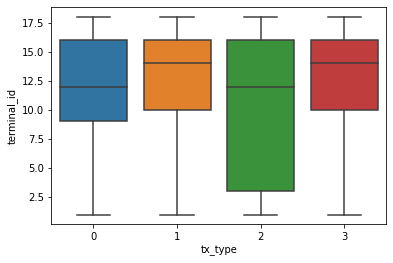

In [9]:
sns.boxplot(x='tx_type',y='terminal_id',data=data)


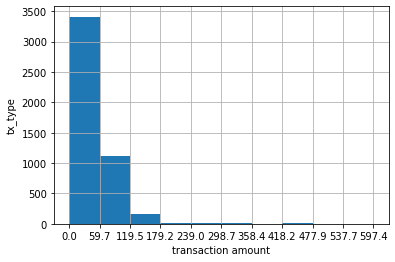

In [10]:
count,bin_edges = np.histogram(data['tx_amount'])
data['tx_amount'].plot(kind='hist',xticks=bin_edges)
plt.xlabel('transaction amount')
plt.ylabel('tx_type')
plt.grid()
plt.show()

In [11]:
data.describe()

,customer_id,datetime,tx_amount,terminal_id,tx_type
count,4745.000000,4.745000e+03,4745.000000,4745.000000,4745.000000
mean,263.093151,1.527681e+09,47.428182,10.782086,1.660274
std,147.278627,2.978393e+06,43.331870,5.451547,0.867286
min,15.000000,1.522532e+09,0.010000,1.000000,0.000000
25%,132.000000,1.525154e+09,18.240000,5.000000,2.000000
50%,235.000000,1.527664e+09,39.220001,12.000000,2.000000
75%,405.000000,1.530250e+09,63.709999,16.000000,2.000000
max,498.000000,1.533039e+09,597.400024,18.000000,3.000000


<AxesSubplot:xlabel='tx_amount', ylabel='tx_type'>

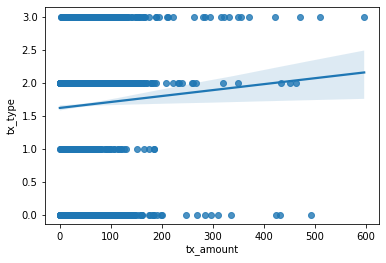

In [12]:
sns.regplot(x='tx_amount', y='tx_type', data=data)

In [13]:
data['customer_id'].unique()

array([ 28, 296, 188, 129, 337, 187, 466, 235,  15,  79, 367, 142, 144,
       498, 291, 122, 226, 286,  50, 150, 411, 132,  94, 405, 363, 467,
        16, 451, 420])

In [14]:
data['customer_id'].value_counts()

466    418
188    408
129    405
235    350
498    349
367    269
144    258
467    237
122    215
187    202
363    198
28     196
291    195
132    168
226    160
337    153
405    117
50      79
94      75
15      72
16      43
411     41
286     32
150     27
296     22
142     19
420     19
451     14
79       4
Name: customer_id, dtype: int64

### Preparing the data.
### Input features = X,
### Output feature = y.

In [15]:
X = data[[
    'datetime',
    'tx_amount',
    'terminal_id',
    'tx_type'
]]

y = data[
    "customer_id"
]

In [16]:
X


,datetime,tx_amount,terminal_id,tx_type
0,1.522539e+09,84.230003,17,0
1,1.522585e+09,120.649994,15,3
2,1.522543e+09,53.290001,16,0
3,1.522548e+09,29.950001,16,0
4,1.522549e+09,10.310000,16,0
...,...,...,...,...
4740,1.532853e+09,78.720001,17,2
4741,1.532923e+09,47.520000,16,0
4742,1.532952e+09,125.110001,18,3
4743,1.533008e+09,185.113356,16,0


In [17]:
y

0        28
1       296
2       188
3       188
4       188
       ... 
4740    467
4741    467
4742    467
4743    467
4744    467
Name: customer_id, Length: 4745, dtype: int64

#### Spliting the data into train and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3,
                                                   random_state=42
                                                   )


In [19]:
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape :", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape : (3321, 4)
X_test shape : (1424, 4)
y_train shape : (3321,)
y_test shape : (1424,)


In [20]:
lgr = LogisticRegression()

try:
    lgr = joblib.load(lgr_modelPath)
    print("Logistic regression model has been loaded")
    
except:
    try:
        lgr = lgr.fit(X_train, y_train)
        print("LGR Model has been fitted")
        
    except:
        if lgr is None:
            print("LGR Model is None")
            
    try:
        if lgr is not None:
            joblib.dump(lgr, lgr_modelPath)
            print("LGR Model has been written to disk")
            
    except:
        print("Unable to write LGR Model to disk")

Logistic regression model has been loaded


In [21]:
lgr_pred = lgr.predict(X_test)
print(lgr_pred)

[188 188 188 ... 188 188 188]


In [22]:
lgr_accu = accuracy_score(lgr_pred, y_test) * 100
lgr_rec = recall_score(lgr_pred, y_test, average='micro') * 100
lgr_pre = precision_score(lgr_pred, y_test, average='micro') * 100
lgr_f1 = f1_score(lgr_pred, y_test, average='micro') * 100
print(
    "lgr_pred : ", lgr_pred, "\n"
    "accuracy : ", lgr_accu, "\n"
    "recall :", lgr_rec, "\n"
    "precision : ", lgr_pre, "\n"
    "f1_score :", lgr_f1, "\n"
)

lgr_pred :  [188 188 188 ... 188 188 188] 
accuracy :  7.724719101123595 
recall : 7.724719101123595 
precision :  7.724719101123595 
f1_score : 7.724719101123595 



#### Use iloc when looping a series like y_test.

In [23]:
for i in range(len(y_test)):
    print("i= %s, orignally= %s, Predicted= %s" % (i, y_test.iloc[i], lgr_pred[i]))
    #print()

i= 0, orignally= 235, Predicted= 188
i= 1, orignally= 235, Predicted= 188
i= 2, orignally= 188, Predicted= 188
i= 3, orignally= 122, Predicted= 188
i= 4, orignally= 122, Predicted= 188
i= 5, orignally= 129, Predicted= 188
i= 6, orignally= 129, Predicted= 188
i= 7, orignally= 466, Predicted= 188
i= 8, orignally= 187, Predicted= 188
i= 9, orignally= 291, Predicted= 188
i= 10, orignally= 79, Predicted= 188
i= 11, orignally= 15, Predicted= 188
i= 12, orignally= 363, Predicted= 188
i= 13, orignally= 144, Predicted= 188
i= 14, orignally= 188, Predicted= 188
i= 15, orignally= 291, Predicted= 188
i= 16, orignally= 129, Predicted= 188
i= 17, orignally= 405, Predicted= 188
i= 18, orignally= 144, Predicted= 188
i= 19, orignally= 466, Predicted= 188
i= 20, orignally= 337, Predicted= 188
i= 21, orignally= 367, Predicted= 188
i= 22, orignally= 142, Predicted= 188
i= 23, orignally= 28, Predicted= 188
i= 24, orignally= 129, Predicted= 188
i= 25, orignally= 411, Predicted= 188
i= 26, orignally= 405, Pr

In [24]:
y_test.iloc[0]

235

In [25]:
print(len(y_test))
print(len(lgr_pred))

1424
1424


In [26]:
# g=plt.plot(y_test - lgr_pred, marker='o', linestyle='')


(12.590250030438092, 1045.4836105190263, 89.12509381337455, 1122.018454301963)

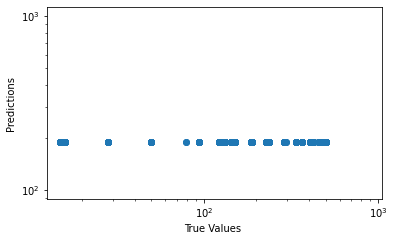

In [27]:
g=plt.scatter(y_test, lgr_pred)
g.axes.set_yscale('log')
g.axes.set_xscale('log')
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')

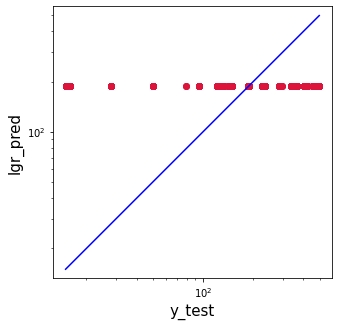

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, lgr_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(lgr_pred), max(y_test))
p2 = min(min(lgr_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('lgr_pred', fontsize=15)
plt.axis('equal')
plt.show()

### DecisionTree Classifier()

In [29]:
dtc = DecisionTreeClassifier()

try:
    dtc = joblib.load(dt_modelPath)
    print("Decision Tree model has been loaded.")

except:
    try:
        dtc = dtc.fit(X_train, y_train)
        
    except:
        if dtc is None:
            print("Model is None")
    try:
        if dtc is not None:
            joblib.dump(dtc, dt_modelPath)
            print("Model has been saved to disk")
            
    except:
        print("Unable to write model to disk")


Decision Tree model has been loaded.


In [30]:
dtc_pred = dtc.predict(X_test)
dtc_accu = accuracy_score(dtc_pred, y_test) * 100
dtc_rec = recall_score(dtc_pred, y_test, average='micro') * 100
dtc_pre = precision_score(dtc_pred, y_test, average='micro') * 100
dtc_f1 = f1_score(dtc_pred, y_test, average='micro') * 100

print(
    "dtc_pred : ", dtc_pred, "\n"
    "accuracy : ", dtc_accu, "\n"
    "recall :", dtc_rec, "\n"
    "precision : ", dtc_pre, "\n"
    "f1_score :", dtc_f1, "\n"
)

dtc_pred :  [235 235 188 ...  16 466 129] 
accuracy :  69.80337078651685 
recall : 69.80337078651685 
precision :  69.80337078651685 
f1_score : 69.80337078651685 



In [31]:
for i in range(len(y_test)):
    print("i= %s, originally= %s, Predicted= %s" % (i, y_test.iloc[i], dtc_pred[i]))

i= 0, originally= 235, Predicted= 235
i= 1, originally= 235, Predicted= 235
i= 2, originally= 188, Predicted= 188
i= 3, originally= 122, Predicted= 122
i= 4, originally= 122, Predicted= 188
i= 5, originally= 129, Predicted= 129
i= 6, originally= 129, Predicted= 466
i= 7, originally= 466, Predicted= 466
i= 8, originally= 187, Predicted= 187
i= 9, originally= 291, Predicted= 291
i= 10, originally= 79, Predicted= 79
i= 11, originally= 15, Predicted= 15
i= 12, originally= 363, Predicted= 226
i= 13, originally= 144, Predicted= 144
i= 14, originally= 188, Predicted= 122
i= 15, originally= 291, Predicted= 291
i= 16, originally= 129, Predicted= 405
i= 17, originally= 405, Predicted= 129
i= 18, originally= 144, Predicted= 144
i= 19, originally= 466, Predicted= 405
i= 20, originally= 337, Predicted= 337
i= 21, originally= 367, Predicted= 367
i= 22, originally= 142, Predicted= 94
i= 23, originally= 28, Predicted= 28
i= 24, originally= 129, Predicted= 129
i= 25, originally= 411, Predicted= 142
i= 

i= 944, originally= 466, Predicted= 466
i= 945, originally= 405, Predicted= 466
i= 946, originally= 122, Predicted= 122
i= 947, originally= 367, Predicted= 367
i= 948, originally= 498, Predicted= 498
i= 949, originally= 129, Predicted= 129
i= 950, originally= 235, Predicted= 235
i= 951, originally= 235, Predicted= 235
i= 952, originally= 187, Predicted= 188
i= 953, originally= 188, Predicted= 188
i= 954, originally= 122, Predicted= 188
i= 955, originally= 291, Predicted= 291
i= 956, originally= 188, Predicted= 188
i= 957, originally= 466, Predicted= 405
i= 958, originally= 144, Predicted= 144
i= 959, originally= 420, Predicted= 467
i= 960, originally= 367, Predicted= 367
i= 961, originally= 144, Predicted= 144
i= 962, originally= 498, Predicted= 498
i= 963, originally= 363, Predicted= 363
i= 964, originally= 16, Predicted= 466
i= 965, originally= 498, Predicted= 498
i= 966, originally= 367, Predicted= 367
i= 967, originally= 226, Predicted= 226
i= 968, originally= 467, Predicted= 122
i

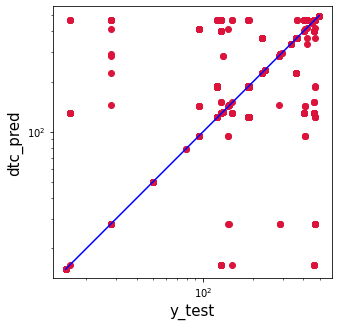

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, dtc_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(dtc_pred), max(y_test))
p2 = min(min(dtc_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('dtc_pred', fontsize=15)
plt.axis('equal')
plt.show()

### RF CLF

In [33]:
rfc = RandomForestClassifier()

try:
    rfc = joblib.load(rfc_modelPath)
    print("Random Forest Classifier Model Has Been Loaded.")
    
except:
    try:
        rfc = rfc.fit(X_train, y_train)
        
    except:
        if rfc is None:
            print("Model Is None")
            
    try:
        if rfc is not None:
            joblib.dump(rfc, rfc_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

Random Forest Classifier Model Has Been Loaded.


In [59]:
rfc_pred = rfc.predict(X_test)
rfc_accu = accuracy_score(y_test, rfc_pred) * 100
rfc_rec = recall_score(y_test, rfc_pred, average='macro') * 100
rfc_pre = precision_score(y_test, rfc_pred, average="macro") * 100
rfc_f1 = f1_score(y_test, rfc_pred, average="macro") * 100

print(
    "rfc_pred : ", rfc_pred, "\n"
    "accuracy : ", rfc_accu, "\n"
    "recall :",    rfc_rec, "\n"
    "precision : ", rfc_pre, "\n"
    "f1_score :", rfc_f1, "\n"
)

rfc_pred :  [235 235 188 ... 129 466 129] 
accuracy :  73.87640449438202 
recall : 68.91044560454237 
precision :  68.98851368214338 
f1_score : 68.20981466317612 



/data/asjad/Project/venv/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
for i in range(len(y_test)):
    print("i= %s , y_test= %s , Predicted= %s" % (i, y_test.iloc[i], rfc_pred[i]))

i= 0 , y_test= 235 , Predicted= 235
i= 1 , y_test= 235 , Predicted= 235
i= 2 , y_test= 188 , Predicted= 188
i= 3 , y_test= 122 , Predicted= 187
i= 4 , y_test= 122 , Predicted= 122
i= 5 , y_test= 129 , Predicted= 129
i= 6 , y_test= 129 , Predicted= 466
i= 7 , y_test= 466 , Predicted= 466
i= 8 , y_test= 187 , Predicted= 188
i= 9 , y_test= 291 , Predicted= 291
i= 10 , y_test= 79 , Predicted= 79
i= 11 , y_test= 15 , Predicted= 15
i= 12 , y_test= 363 , Predicted= 226
i= 13 , y_test= 144 , Predicted= 144
i= 14 , y_test= 188 , Predicted= 188
i= 15 , y_test= 291 , Predicted= 291
i= 16 , y_test= 129 , Predicted= 405
i= 17 , y_test= 405 , Predicted= 129
i= 18 , y_test= 144 , Predicted= 144
i= 19 , y_test= 466 , Predicted= 466
i= 20 , y_test= 337 , Predicted= 337
i= 21 , y_test= 367 , Predicted= 367
i= 22 , y_test= 142 , Predicted= 94
i= 23 , y_test= 28 , Predicted= 28
i= 24 , y_test= 129 , Predicted= 129
i= 25 , y_test= 411 , Predicted= 94
i= 26 , y_test= 405 , Predicted= 466
i= 27 , y_test= 466

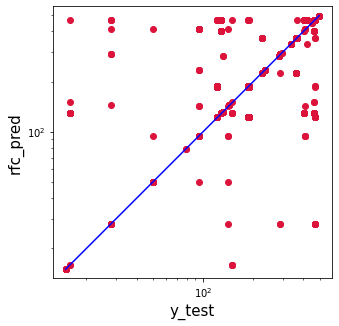

In [36]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, rfc_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(rfc_pred), max(y_test))
p2 = min(min(rfc_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('rfc_pred', fontsize=15)
plt.axis('equal')
plt.show()

### KNN

In [37]:
knn = KNeighborsClassifier()

try:
    knn = joblib.load(knn_modelPath)
    print("Random Forest Classifier Model Has Been Loaded.")
    
except:
    try:
        knn = knn.fit(X_train, y_train)
        
    except:
        if knn is None:
            print("Model Is None")
            
    try:
        if knn is not None:
            joblib.dump(knn, knn_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

Random Forest Classifier Model Has Been Loaded.


In [38]:
knn_pred = knn.predict(X_test)
knn_accu = accuracy_score(y_test, knn_pred)*100
knn_rec = recall_score(y_test, knn_pred, average='micro')*100
knn_pre = precision_score(y_test, knn_pred, average='micro')*100
knn_f1 = f1_score(y_test, knn_pred, average='micro')*100

print(
    "knn_pred : ", knn_pred, "\n"
    "accuracy : ", knn_accu, "\n"
    "recall :",    knn_rec, "\n"
    "precision : ", knn_pre, "\n"
    "f1_score :", knn_f1, "\n"
)

knn_pred :  [122  15 129 ... 129  15 129] 
accuracy :  5.828651685393258 
recall : 5.828651685393258 
precision :  5.828651685393258 
f1_score : 5.828651685393258 



In [39]:
for i in range(len(y_test)):
    print("i= %s , y_test= %s, Predicted= %s" % (i, y_test.iloc[i], knn_pred[i]))

i= 0 , y_test= 235, Predicted= 122
i= 1 , y_test= 235, Predicted= 15
i= 2 , y_test= 188, Predicted= 129
i= 3 , y_test= 122, Predicted= 28
i= 4 , y_test= 122, Predicted= 367
i= 5 , y_test= 129, Predicted= 28
i= 6 , y_test= 129, Predicted= 129
i= 7 , y_test= 466, Predicted= 187
i= 8 , y_test= 187, Predicted= 129
i= 9 , y_test= 291, Predicted= 15
i= 10 , y_test= 79, Predicted= 188
i= 11 , y_test= 15, Predicted= 235
i= 12 , y_test= 363, Predicted= 122
i= 13 , y_test= 144, Predicted= 16
i= 14 , y_test= 188, Predicted= 144
i= 15 , y_test= 291, Predicted= 129
i= 16 , y_test= 129, Predicted= 498
i= 17 , y_test= 405, Predicted= 363
i= 18 , y_test= 144, Predicted= 15
i= 19 , y_test= 466, Predicted= 50
i= 20 , y_test= 337, Predicted= 367
i= 21 , y_test= 367, Predicted= 15
i= 22 , y_test= 142, Predicted= 129
i= 23 , y_test= 28, Predicted= 235
i= 24 , y_test= 129, Predicted= 16
i= 25 , y_test= 411, Predicted= 122
i= 26 , y_test= 405, Predicted= 28
i= 27 , y_test= 466, Predicted= 144
i= 28 , y_test=

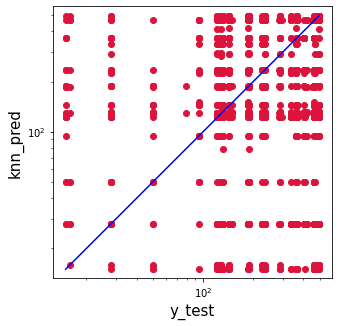

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, knn_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(knn_pred), max(y_test))
p2 = min(min(knn_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('knn_pred', fontsize=15)
plt.axis('equal')
plt.show()

### Gausian Naive Bayes

In [41]:
gnb = GaussianNB()

try:
    gnb = joblib.load(gnb_modelPath)
    print("Gausian Naive Bayes Classifier Model Has Been Loaded.")
    
except:
    try:
        gnb = gnb.fit(X_train, y_train)
        
    except:
        if gnb is None:
            print("Model Is None")
            
    try:
        if gnb is not None:
            joblib.dump(gnb, gnb_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

Gausian Naive Bayes Classifier Model Has Been Loaded.


In [42]:
gnb_pred = gnb.predict(X_test)
gnb_accu = accuracy_score(y_test, gnb_pred) * 100
gnb_rec = recall_score(y_test, gnb_pred, average='micro') * 100
gnb_pre = precision_score(y_test, gnb_pred, average='micro') * 100
gnb_f1 = f1_score(y_test, gnb_pred, average='micro') * 100

print(
    "gnb_pred : ", gnb_pred, "\n"
    "accuracy : ", gnb_accu, "\n"
    "recall :",    gnb_rec, "\n"
    "precision : ", gnb_pre, "\n"
    "f1_score :", gnb_f1, "\n"
)

gnb_pred :  [188 188 188 ... 466 188 188] 
accuracy :  10.814606741573034 
recall : 10.814606741573034 
precision :  10.814606741573034 
f1_score : 10.814606741573035 



In [43]:
for i in range(len(y_test)):
    print("i= %s, X= %s, Predicted= %s" % (i, y_test.iloc[i], gnb_pred[i]))

i= 0, X= 235, Predicted= 188
i= 1, X= 235, Predicted= 188
i= 2, X= 188, Predicted= 188
i= 3, X= 122, Predicted= 188
i= 4, X= 122, Predicted= 188
i= 5, X= 129, Predicted= 188
i= 6, X= 129, Predicted= 188
i= 7, X= 466, Predicted= 188
i= 8, X= 187, Predicted= 188
i= 9, X= 291, Predicted= 188
i= 10, X= 79, Predicted= 129
i= 11, X= 15, Predicted= 188
i= 12, X= 363, Predicted= 188
i= 13, X= 144, Predicted= 188
i= 14, X= 188, Predicted= 188
i= 15, X= 291, Predicted= 188
i= 16, X= 129, Predicted= 129
i= 17, X= 405, Predicted= 188
i= 18, X= 144, Predicted= 188
i= 19, X= 466, Predicted= 188
i= 20, X= 337, Predicted= 466
i= 21, X= 367, Predicted= 188
i= 22, X= 142, Predicted= 188
i= 23, X= 28, Predicted= 466
i= 24, X= 129, Predicted= 129
i= 25, X= 411, Predicted= 129
i= 26, X= 405, Predicted= 188
i= 27, X= 466, Predicted= 188
i= 28, X= 144, Predicted= 188
i= 29, X= 498, Predicted= 235
i= 30, X= 122, Predicted= 188
i= 31, X= 150, Predicted= 466
i= 32, X= 291, Predicted= 188
i= 33, X= 291, Predicte

i= 849, X= 122, Predicted= 235
i= 850, X= 16, Predicted= 129
i= 851, X= 467, Predicted= 129
i= 852, X= 337, Predicted= 188
i= 853, X= 235, Predicted= 235
i= 854, X= 363, Predicted= 188
i= 855, X= 122, Predicted= 235
i= 856, X= 367, Predicted= 188
i= 857, X= 94, Predicted= 188
i= 858, X= 132, Predicted= 235
i= 859, X= 188, Predicted= 235
i= 860, X= 363, Predicted= 188
i= 861, X= 94, Predicted= 188
i= 862, X= 16, Predicted= 129
i= 863, X= 122, Predicted= 188
i= 864, X= 235, Predicted= 188
i= 865, X= 28, Predicted= 188
i= 866, X= 132, Predicted= 188
i= 867, X= 28, Predicted= 466
i= 868, X= 15, Predicted= 466
i= 869, X= 367, Predicted= 235
i= 870, X= 467, Predicted= 188
i= 871, X= 498, Predicted= 188
i= 872, X= 144, Predicted= 188
i= 873, X= 188, Predicted= 235
i= 874, X= 187, Predicted= 188
i= 875, X= 122, Predicted= 188
i= 876, X= 188, Predicted= 188
i= 877, X= 235, Predicted= 188
i= 878, X= 132, Predicted= 188
i= 879, X= 466, Predicted= 188
i= 880, X= 226, Predicted= 235
i= 881, X= 466,

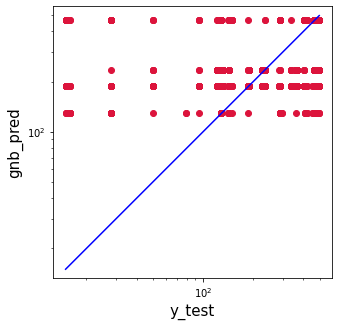

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, gnb_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(gnb_pred), max(y_test))
p2 = min(min(gnb_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('gnb_pred', fontsize=15)
plt.axis('equal')
plt.show()

### RFR

In [45]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=15,
                           max_features='sqrt',
                           random_state=42)

try:
    rfr = joblib.load(rfr_modelPath)
    print("RandomForest Regressor Model Has Been Loaded.")
    
except:
    try:
        rfr = rfr.fit(X_train, y_train)
        
    except:
        if rfr is None:
            print("Model Is None")
            
    try:
        if rfr is not None:
            joblib.dump(rfr, rfr_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

RandomForest Regressor Model Has Been Loaded.


In [46]:
rfr = rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_rmse = rfr_mse**.5

print(
    "rfr_pred : ", rfr_pred, "\n"
    "mean squared error : ", rfr_mse, "\n"
    "root mean squared error :", rfr_rmse,
)

rfr_pred :  [232.89468562 236.07841646 173.88583184 ... 124.2003225  331.87655388
 306.24130884] 
mean squared error :  8703.117652124658 
root mean squared error : 93.29050140354407


In [47]:
for i in range(len(y_test)):
    print("i= %s, X= %s, Predicted= %s" % (i, y_test.iloc[i], rfr_pred[i]))

i= 0, X= 235, Predicted= 232.89468561728393
i= 1, X= 235, Predicted= 236.078416457103
i= 2, X= 188, Predicted= 173.88583184449115
i= 3, X= 122, Predicted= 188.55829004652836
i= 4, X= 122, Predicted= 168.52076537245748
i= 5, X= 129, Predicted= 304.29166550666616
i= 6, X= 129, Predicted= 340.8814551605067
i= 7, X= 466, Predicted= 377.112393613628
i= 8, X= 187, Predicted= 164.32411794354257
i= 9, X= 291, Predicted= 285.0306091307067
i= 10, X= 79, Predicted= 259.36809557620103
i= 11, X= 15, Predicted= 52.3
i= 12, X= 363, Predicted= 249.62560038010974
i= 13, X= 144, Predicted= 175.39564417344175
i= 14, X= 188, Predicted= 174.8545773701869
i= 15, X= 291, Predicted= 291.3842939019814
i= 16, X= 129, Predicted= 324.0011722906784
i= 17, X= 405, Predicted= 309.20401631516074
i= 18, X= 144, Predicted= 160.20423369488236
i= 19, X= 466, Predicted= 387.74705644909153
i= 20, X= 337, Predicted= 322.89283920752774
i= 21, X= 367, Predicted= 364.79
i= 22, X= 142, Predicted= 121.3321743003262
i= 23, X= 28,

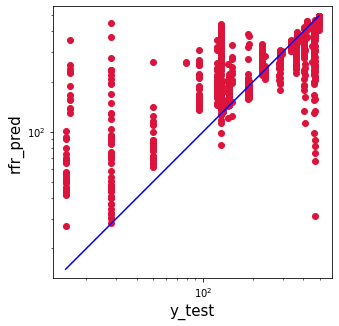

In [48]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, rfr_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(rfr_pred), max(y_test))
p2 = min(min(rfr_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('rfr_pred', fontsize=15)
plt.axis('equal')
plt.show()

### RFR GridSearch CV

In [49]:
## Define Grid 
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [42]
}

## Grid Search function
cv_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)

try:
    cv_rfr = joblib.load(cv_rfr_modelPath)
    print("RandomForest Regressor Model Has Been Loaded.")
    
except:
    try:
        cv_rfr = cv_rfr.fit(X_train, y_train)
        
    except:
        if cv_rfr is None:
            print("Model Is None")
            
    try:
        if cv_rfr is not None:
            joblib.dump(cv_rfr, cv_rfr_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

RandomForest Regressor Model Has Been Loaded.


In [50]:
cv_rfr_pred = cv_rfr.predict(X_test)
cv_rfr_mse = mean_squared_error(y_test, cv_rfr_pred)
cv_rfr_rmse = cv_rfr_mse**.5

print(
    "cv_rfr_pred : ", cv_rfr_pred, "\n"
    "mean squared error : ", cv_rfr_mse, "\n"
    "root mean squared error :", cv_rfr_rmse,
)

cv_rfr_pred :  [229.67221391 223.85912338 175.53718085 ... 181.21201459 314.8249007
 313.27110415] 
mean squared error :  9397.494110405309 
root mean squared error : 96.94067314809253


In [51]:
for i in range(len(y_test)):
    print("i= %s, X= %s, Predicted= %s" % (i, y_test.iloc[i], cv_rfr_pred[i]))

i= 0, X= 235, Predicted= 229.67221390601983
i= 1, X= 235, Predicted= 223.8591233774361
i= 2, X= 188, Predicted= 175.5371808470196
i= 3, X= 122, Predicted= 217.76500940480793
i= 4, X= 122, Predicted= 176.4824295619515
i= 5, X= 129, Predicted= 313.70788288893834
i= 6, X= 129, Predicted= 349.2633554424657
i= 7, X= 466, Predicted= 358.656093511467
i= 8, X= 187, Predicted= 173.79906847693755
i= 9, X= 291, Predicted= 260.712256831044
i= 10, X= 79, Predicted= 259.4082004339987
i= 11, X= 15, Predicted= 109.96398524140179
i= 12, X= 363, Predicted= 263.940640726787
i= 13, X= 144, Predicted= 202.1788974667982
i= 14, X= 188, Predicted= 177.05180220242462
i= 15, X= 291, Predicted= 263.984104287269
i= 16, X= 129, Predicted= 287.8134309187086
i= 17, X= 405, Predicted= 318.07763937925347
i= 18, X= 144, Predicted= 176.50642771144746
i= 19, X= 466, Predicted= 354.90656522392715
i= 20, X= 337, Predicted= 319.14695196473446
i= 21, X= 367, Predicted= 353.7717172238957
i= 22, X= 142, Predicted= 210.16855504

i= 1081, X= 132, Predicted= 168.92732658493284
i= 1082, X= 367, Predicted= 365.15503777965785
i= 1083, X= 367, Predicted= 372.01678122997686
i= 1084, X= 235, Predicted= 222.3108401299024
i= 1085, X= 226, Predicted= 250.7171691853688
i= 1086, X= 466, Predicted= 307.2660435821629
i= 1087, X= 188, Predicted= 176.49966167665139
i= 1088, X= 132, Predicted= 168.45917022341214
i= 1089, X= 498, Predicted= 483.1779942692708
i= 1090, X= 498, Predicted= 490.6663317503397
i= 1091, X= 144, Predicted= 193.38749550526464
i= 1092, X= 467, Predicted= 298.99203887108945
i= 1093, X= 498, Predicted= 490.27243327861567
i= 1094, X= 122, Predicted= 175.58712092814056
i= 1095, X= 291, Predicted= 252.21887029811305
i= 1096, X= 188, Predicted= 175.29979843471992
i= 1097, X= 129, Predicted= 355.72662514681906
i= 1098, X= 466, Predicted= 243.91573927231835
i= 1099, X= 367, Predicted= 364.2608166489632
i= 1100, X= 367, Predicted= 368.5653678983724
i= 1101, X= 188, Predicted= 175.3189999956239
i= 1102, X= 286, Pred

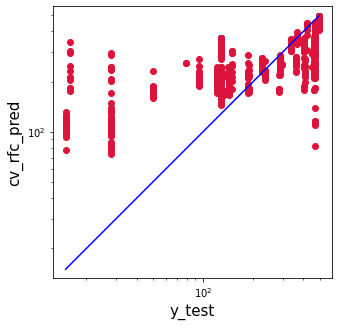

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, cv_rfr_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(cv_rfr_pred), max(y_test))
p2 = min(min(cv_rfr_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('cv_rfc_pred', fontsize=15)
plt.axis('equal')
plt.show()

### Linear Regression

In [53]:
lr = LinearRegression()

try:
    lr = joblib.load(lr_modelPath)
    print("RandomForest Regressor Model Has Been Loaded.")
    
except:
    try:
        lr = lr.fit(X_train, y_train)
        
    except:
        if lr is None:
            print("Model Is None")
            
    try:
        if lr is not None:
            joblib.dump(lr, lr_modelPath)
            print("Model Has Been Written to Disk.")
            
    except:
        print("Unable To Write Model To Disk.")

RandomForest Regressor Model Has Been Loaded.


In [54]:
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = lr_mse**.5
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
cv_lr_mse = np.mean(scores)
cv_lr_rmse = np.std(scores) 

print(
    "lr_pred : ", lr_pred, "\n"
    "mean squared error : ", lr_mse, "\n"
    "root mean squared error :", lr_rmse, "\n"
    "cv_lr_mse :", cv_lr_mse, "\n"
    "cv_lr_rmse :", cv_lr_rmse, "\n"
    "lr_intercept :", lr.intercept_, "\n"
    "lr_coef :", lr.coef_
)

lr_pred :  [284.6354647  281.51319106 233.68284529 ... 302.37721899 305.92234758
 302.25288534] 
mean squared error :  21067.878517831756 
root mean squared error : 145.14778164970954 
cv_lr_mse : 0.04570108151096244 
cv_lr_rmse : 0.014194835019371356 
lr_intercept : -1265.2297042906732 
lr_coef : [ 1.05191530e-06 -1.84732935e-01 -5.88200328e+00 -3.59598405e+00]


In [55]:
for i in range(len(y_test)):
    print("i= %s, X= %s, Predicted= %s" % (i, y_test.iloc[i], lr_pred[i]))

i= 0, X= 235, Predicted= 284.6354646990137
i= 1, X= 235, Predicted= 281.5131910629623
i= 2, X= 188, Predicted= 233.68284528506706
i= 3, X= 122, Predicted= 242.28387395323898
i= 4, X= 122, Predicted= 235.97610081989842
i= 5, X= 129, Predicted= 306.5936038850334
i= 6, X= 129, Predicted= 307.19885671283623
i= 7, X= 466, Predicted= 314.34565441140603
i= 8, X= 187, Predicted= 244.08558955358876
i= 9, X= 291, Predicted= 250.60654107976507
i= 10, X= 79, Predicted= 263.88762362250736
i= 11, X= 15, Predicted= 313.7507591406329
i= 12, X= 363, Predicted= 267.7879766836993
i= 13, X= 144, Predicted= 251.42749337777627
i= 14, X= 188, Predicted= 232.05105658724506
i= 15, X= 291, Predicted= 257.0378596991443
i= 16, X= 129, Predicted= 298.1387611989285
i= 17, X= 405, Predicted= 304.52697863063713
i= 18, X= 144, Predicted= 248.5820496961494
i= 19, X= 466, Predicted= 311.3996018561836
i= 20, X= 337, Predicted= 306.84133233012767
i= 21, X= 367, Predicted= 236.04092060892367
i= 22, X= 142, Predicted= 271.1

i= 552, X= 363, Predicted= 259.4931311164021
i= 553, X= 235, Predicted= 283.2380209995913
i= 554, X= 466, Predicted= 306.14340995191014
i= 555, X= 188, Predicted= 231.56834186269316
i= 556, X= 466, Predicted= 311.4769003429392
i= 557, X= 188, Predicted= 229.84854426976813
i= 558, X= 28, Predicted= 219.1696407319107
i= 559, X= 466, Predicted= 305.18687383242764
i= 560, X= 122, Predicted= 226.44130932827375
i= 561, X= 337, Predicted= 294.8357152762094
i= 562, X= 498, Predicted= 295.9874910305557
i= 563, X= 187, Predicted= 229.58805761230633
i= 564, X= 129, Predicted= 301.52323786683564
i= 565, X= 337, Predicted= 291.07768543310044
i= 566, X= 405, Predicted= 303.4113240798895
i= 567, X= 466, Predicted= 305.7719455080021
i= 568, X= 188, Predicted= 235.47006688549322
i= 569, X= 363, Predicted= 270.3914378055597
i= 570, X= 188, Predicted= 238.44439330144496
i= 571, X= 235, Predicted= 284.83378269620493
i= 572, X= 122, Predicted= 232.8486094130633
i= 573, X= 337, Predicted= 301.687465131256
i

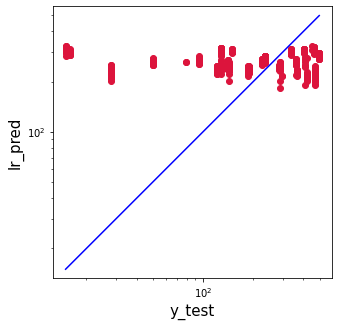

In [56]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, lr_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(lr_pred), max(y_test))
p2 = min(min(lr_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('lr_pred', fontsize=15)
plt.axis('equal')
plt.show()

### dataframe with evaluation metrics accuracy, f1-score, recall, precision

In [57]:
clf = ["GNB", "RFC", "KNN", "DTC", "LogR"]
acc = [gnb_accu, rfc_accu, knn_accu, dtc_accu, lgr_accu]
rec = [gnb_rec, rfc_rec, knn_rec, dtc_rec, lgr_rec]
pre = [gnb_pre, rfc_pre, knn_pre, dtc_pre, lgr_pre]
f1 = [gnb_f1, rfc_f1, knn_f1, dtc_f1, lgr_f1]


score = pd.DataFrame({
    "classifier": clf,
    "accuracy": acc,
    "recall": rec,
    "precision": pre,
    "f1_score": f1,
})

score.set_index("classifier", inplace = True)
score = score.transpose()
score["high score"] = score[["GNB", "RFC", "KNN", "DTC", "LogR"]].idxmax(axis=1)
display("Algorithm Performance", score)


'Algorithm Performance'

classifier,GNB,RFC,KNN,DTC,LogR,high score
accuracy,10.814607,73.876404,5.828652,69.803371,7.724719,RFC
recall,10.814607,73.876404,5.828652,69.803371,7.724719,RFC
precision,10.814607,73.876404,5.828652,69.803371,7.724719,RFC
f1_score,10.814607,73.876404,5.828652,69.803371,7.724719,RFC


### dataframe with evaluation mean square error and root mean squared error

In [58]:
reg = ["RFR", "CV_RFR", "LR", "CV_LR"]
mse = [rfr_mse, cv_rfr_mse, lr_mse, cv_lr_mse]
rmse = [rfr_rmse, cv_rfr_rmse, lr_rmse, cv_lr_rmse]


score = pd.DataFrame({
    "regressor": reg,
    "mean_sq_error": mse,
    "root_mean_sq_error": rmse,
})

score.set_index("regressor", inplace = True)
score = score.transpose()
score["high error"] = score[["RFR", "CV_RFR", "LR", "CV_LR"]].idxmax(axis=1)
display("Algorithm Performance", score)

'Algorithm Performance'

regressor,RFR,CV_RFR,LR,CV_LR,high error
mean_sq_error,8703.117652,9397.494110,21067.878518,0.045701,LR
root_mean_sq_error,93.290501,96.940673,145.147782,0.014195,LR
